Import all needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
import requests
import json

Read the dataset

In [2]:
df = pd.read_csv("pt.csv")
df.head()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Lisbon,38.7452,-9.1604,Portugal,PT,Lisboa,primary,506654.0,506654.0
1,Vila Nova de Gaia,41.1333,-8.6167,Portugal,PT,Porto,minor,302295.0,302295.0
2,Porto,41.1495,-8.6108,Portugal,PT,Porto,admin,237591.0,237591.0
3,Braga,41.5333,-8.4167,Portugal,PT,Braga,admin,181494.0,181494.0
4,Matosinhos,41.2077,-8.6674,Portugal,PT,Porto,minor,175478.0,175478.0


Clean the unneeded columns, removing the island and minor cities (client requirements)

In [3]:
df.dropna(inplace=True)
df.drop(["population", "population_proper", "country", "iso2"], axis=1, inplace=True)
df = df[df.admin_name != "Madeira"]
df = df[df.admin_name != "Azores"]
df = df[df.capital != "minor"]
df.drop(["admin_name", "capital"], axis=1, inplace=True)
df = df.reset_index(drop=True)
df

,city,lat,lng
0,Lisbon,38.7452,-9.1604
1,Porto,41.1495,-8.6108
2,Braga,41.5333,-8.4167
3,Coimbra,40.2111,-8.4291
4,Leiria,39.7431,-8.8069
5,Setúbal,38.5243,-8.8926
6,Viseu,40.6667,-7.9167
7,Viana do Castelo,41.7000,-8.8333
8,Aveiro,40.6389,-8.6553
9,Faro,37.0167,-7.9333


Plot of the cities

In [4]:

address = 'Portugal'

geolocator = Nominatim(user_agent="PT_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Portugal are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Portugal are 40.0332629, -7.8896263.


In [5]:
pt_map = folium.Map(location=[latitude, longitude], zoom_start=6)

for lat, lng, city in zip(df.lat, df.lng, df.city):
    label = city
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(pt_map)
pt_map

<sup>If you are reading this notebook on github, please refer to the README to be able to see the maps.</sup>

Remove cities by the sea.

In [6]:
sea_cities = ["Viana do Castelo", "Porto", "Aveiro", "Lisbon", "Setúbal", "Faro"]
for city in sea_cities:
    df = df[df.city != city]
df = df.reset_index(drop=True)
df

,city,lat,lng
0,Braga,41.5333,-8.4167
1,Coimbra,40.2111,-8.4291
2,Leiria,39.7431,-8.8069
3,Viseu,40.6667,-7.9167
4,Santarém,39.2369,-8.6850
5,Castelo Branco,39.8230,-7.4931
6,Évora,38.5667,-7.9000
7,Vila Real,41.3002,-7.7398
8,Guarda,40.5364,-7.2683
9,Beja,38.0333,-7.8833


Divide the country in regions using k means clusters, to be easier to choose.

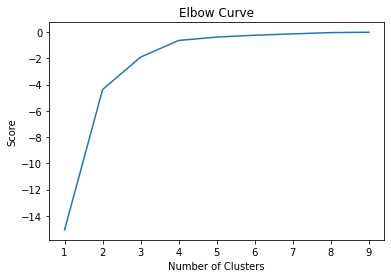

In [7]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df[['lat']]
X_axis = df[['lng']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [8]:
# set number of clusters
kclusters = 3

to_clustering = df.drop('city', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(to_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
df.insert(0, 'Cluster Labels', kmeans.labels_)

df

,Cluster Labels,city,lat,lng
0,0,Braga,41.5333,-8.4167
1,2,Coimbra,40.2111,-8.4291
2,2,Leiria,39.7431,-8.8069
3,0,Viseu,40.6667,-7.9167
4,2,Santarém,39.2369,-8.6850
5,2,Castelo Branco,39.8230,-7.4931
6,1,Évora,38.5667,-7.9000
7,0,Vila Real,41.3002,-7.7398
8,0,Guarda,40.5364,-7.2683
9,1,Beja,38.0333,-7.8833


In [9]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, city, cluster in zip(df.lat, df.lng, df.city, df['Cluster Labels']):
    label = folium.Popup(city + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

<sup>If you are reading this notebook on github, please refer to the README to be able to see the maps.</sup>

Get the venues from Foursquare

In [10]:
%load_ext dotenv
%dotenv
fs_id = os.getenv("client_id")
fs_sec = os.getenv("client_sec")
print('Credentials loaded')

Credentials loaded


In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v=20180605&ll={},{}&radius={}&limit=100'.format(
            fs_id, 
            fs_sec,
            lat, 
            lng, 
            radius)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
pt_venues = getNearbyVenues(names=df['city'],
                                   latitudes=df['lat'],
                                   longitudes=df['lng']
                                  )
pt_venues

Braga
Coimbra
Leiria
Viseu
Santarém
Castelo Branco
Évora
Vila Real
Guarda
Beja
Bragança
Portalegre


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Braga,41.5333,-8.4167,Pastelaria Glicínia 6,41.532088,-8.411738,Bakery
1,Braga,41.5333,-8.4167,Picoto,41.537871,-8.414226,Scenic Lookout
2,Braga,41.5333,-8.4167,Rolha - Restaurante & Garrafeira,41.525942,-8.415884,Portuguese Restaurant
3,Braga,41.5333,-8.4167,Café Imperial,41.538563,-8.409435,Snack Place
4,Braga,41.5333,-8.4167,Recheio Cash & Carry,41.532551,-8.420343,Food & Drink Shop
...,...,...,...,...,...,...,...
460,Bragança,41.8000,-6.7500,Taberna do Javali,41.803690,-6.749352,Portuguese Restaurant
461,Bragança,41.8000,-6.7500,Praça Camões,41.805361,-6.756134,Plaza
462,Portalegre,39.3167,-7.4167,O Malagueta,39.311861,-7.417217,Portuguese Restaurant
463,Portalegre,39.3167,-7.4167,Piscina da Serra,39.309282,-7.420570,Pool


Use One hot encoding to sort the venues by city

In [13]:
# One hot encoding
pt_onehot = pd.get_dummies(pt_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
pt_onehot['City'] = pt_venues['City'] 

# move city column to the first column
fixed_columns = [pt_onehot.columns[-1]] + list(pt_onehot.columns[:-1])
pt_onehot = pt_onehot[fixed_columns]

# Group by cuty
pt_grouped = pt_onehot.groupby('City').mean().reset_index()
pt_grouped

,City,Art Gallery,Art Museum,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Garden,...,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Theater,Theme Park Ride / Attraction,Train Station,Vegetarian / Vegan Restaurant,Wine Bar,Winery
0,Beja,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
1,Braga,0.000000,0.000000,0.040000,0.04,0.000000,0.080000,0.040000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
2,Bragança,0.058824,0.000000,0.000000,0.00,0.000000,0.000000,0.176471,0.058824,0.00,...,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
3,Castelo Branco,0.000000,0.000000,0.000000,0.00,0.000000,0.047619,0.119048,0.000000,0.00,...,0.000000,0.000000,0.023810,0.000000,0.000000,0.000000,0.047619,0.00,0.000000,0.000000
4,Coimbra,0.010000,0.000000,0.000000,0.00,0.000000,0.060000,0.060000,0.010000,0.02,...,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.010000,0.01,0.000000,0.000000
5,Guarda,0.000000,0.000000,0.000000,0.00,0.000000,0.074074,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
6,Leiria,0.000000,0.000000,0.000000,0.00,0.000000,0.025974,0.077922,0.000000,0.00,...,0.038961,0.012987,0.064935,0.000000,0.000000,0.012987,0.000000,0.00,0.012987,0.000000
7,Portalegre,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
8,Santarém,0.000000,0.000000,0.033333,0.00,0.000000,0.000000,0.000000,0.000000,0.00,...,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
9,Vila Real,0.000000,0.000000,0.000000,0.00,0.018868,0.075472,0.075472,0.000000,0.00,...,0.000000,0.000000,0.018868,0.018868,0.018868,0.000000,0.000000,0.00,0.000000,0.018868


merge the dataframes

In [14]:
pt_merged = df

# merge dataframes to add latitude/longitude for each neighborhood
pt_merged = pt_merged.join(pt_grouped.set_index('City'), on='city')

pt_merged

,Cluster Labels,city,lat,lng,Art Gallery,Art Museum,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,...,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Theater,Theme Park Ride / Attraction,Train Station,Vegetarian / Vegan Restaurant,Wine Bar,Winery
0,0,Braga,41.5333,-8.4167,0.000000,0.000000,0.040000,0.04,0.000000,0.080000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
1,2,Coimbra,40.2111,-8.4291,0.010000,0.000000,0.000000,0.00,0.000000,0.060000,...,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.010000,0.01,0.000000,0.000000
2,2,Leiria,39.7431,-8.8069,0.000000,0.000000,0.000000,0.00,0.000000,0.025974,...,0.038961,0.012987,0.064935,0.000000,0.000000,0.012987,0.000000,0.00,0.012987,0.000000
3,0,Viseu,40.6667,-7.9167,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.039216,0.000000,0.000000,0.000000,0.019608,0.000000,0.000000,0.00,0.039216,0.000000
4,2,Santarém,39.2369,-8.6850,0.000000,0.000000,0.033333,0.00,0.000000,0.000000,...,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
5,2,Castelo Branco,39.8230,-7.4931,0.000000,0.000000,0.000000,0.00,0.000000,0.047619,...,0.000000,0.000000,0.023810,0.000000,0.000000,0.000000,0.047619,0.00,0.000000,0.000000
6,1,Évora,38.5667,-7.9000,0.000000,0.026316,0.000000,0.00,0.000000,0.026316,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.00,0.000000,0.000000
7,0,Vila Real,41.3002,-7.7398,0.000000,0.000000,0.000000,0.00,0.018868,0.075472,...,0.000000,0.000000,0.018868,0.018868,0.018868,0.000000,0.000000,0.00,0.000000,0.018868
8,0,Guarda,40.5364,-7.2683,0.000000,0.000000,0.000000,0.00,0.000000,0.074074,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
9,1,Beja,38.0333,-7.8833,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000


Group by cluster and get the most common venues in each cluster

In [15]:
cl_grouped = pt_merged.drop(['city', 'lat', 'lng'], 1).groupby('Cluster Labels').mean().reset_index()
cl_grouped

,Cluster Labels,Art Gallery,Art Museum,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Garden,...,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Theater,Theme Park Ride / Attraction,Train Station,Vegetarian / Vegan Restaurant,Wine Bar,Winery
0,0,0.011765,0.000000,0.008000,0.008,0.003774,0.045909,0.077996,0.015686,0.000,...,0.007843,0.000000,0.015538,0.003774,0.007695,0.000000,0.000000,0.000,0.007843,0.003774
1,1,0.000000,0.013158,0.000000,0.000,0.000000,0.013158,0.013158,0.026316,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013158,0.000,0.000000,0.000000
2,2,0.002000,0.000000,0.006667,0.000,0.000000,0.026719,0.051394,0.002000,0.004,...,0.023126,0.002597,0.019749,0.002000,0.000000,0.002597,0.011524,0.002,0.002597,0.000000


In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cl_sorted = pd.DataFrame(columns=columns)
cl_sorted['Cluster Labels'] = cl_grouped['Cluster Labels']

for ind in np.arange(cl_grouped.shape[0]):
    cl_sorted.iloc[ind, 1:] = return_most_common_venues(cl_grouped.iloc[ind, :], num_top_venues)

cl_sorted

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Café,Portuguese Restaurant,Restaurant,Bar,Bakery
1,1,Restaurant,Food Truck,Portuguese Restaurant,Historic Site,Café
2,2,Portuguese Restaurant,Pool,Bar,Café,Hotel


Choosse cluster 0 based on common venues

In [18]:
region_df = pt_merged[pt_merged['Cluster Labels'] == 0]
region_df = region_df.reset_index(drop=True)
region_df

,Cluster Labels,city,lat,lng,Art Gallery,Art Museum,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,...,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Theater,Theme Park Ride / Attraction,Train Station,Vegetarian / Vegan Restaurant,Wine Bar,Winery
0,0,Braga,41.5333,-8.4167,0.000000,0.0,0.04,0.04,0.000000,0.080000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,0,Viseu,40.6667,-7.9167,0.000000,0.0,0.00,0.00,0.000000,0.000000,...,0.039216,0.0,0.000000,0.000000,0.019608,0.0,0.0,0.0,0.039216,0.000000
2,0,Vila Real,41.3002,-7.7398,0.000000,0.0,0.00,0.00,0.018868,0.075472,...,0.000000,0.0,0.018868,0.018868,0.018868,0.0,0.0,0.0,0.000000,0.018868
3,0,Guarda,40.5364,-7.2683,0.000000,0.0,0.00,0.00,0.000000,0.074074,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0,Bragança,41.8000,-6.7500,0.058824,0.0,0.00,0.00,0.000000,0.000000,...,0.000000,0.0,0.058824,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [19]:
map_region = folium.Map(location=[41.3002, -7.7398], zoom_start=8)

for lat, lng, city in zip(region_df.lat, region_df.lng, region_df.city):
    label = city
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_region)  
    
       
map_region

<sup>If you are reading this notebook on github, please refer to the README to be able to see the maps.</sup>

View the top venues of each city on the chosen cluster

In [20]:
region_df.drop(['Cluster Labels', 'lat', 'lng'], 1, inplace=True)

In [21]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['city']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
reg_sorted = pd.DataFrame(columns=columns)
reg_sorted['city'] = region_df['city']

for ind in np.arange(region_df.shape[0]):
    reg_sorted.iloc[ind, 1:] = return_most_common_venues(region_df.iloc[ind, :], num_top_venues)

reg_sorted

,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Braga,Café,Restaurant,Portuguese Restaurant,Bakery,Italian Restaurant
1,Viseu,Bar,Café,Fast Food Restaurant,Portuguese Restaurant,Hotel
2,Vila Real,Café,Fast Food Restaurant,Bakery,Bar,Park
3,Guarda,Café,Restaurant,Portuguese Restaurant,Bakery,Hotel
4,Bragança,Portuguese Restaurant,Bar,Plaza,Art Gallery,Café


We will choose Braga, followed by Guarda and Viseu as a good second option.